In [1]:
import numpy as np
from sympy import symbols, Matrix
from scipy.integrate import solve_ivp
import scipy.linalg as la
import matplotlib.pylab as plt

In [2]:
tspan = np.linspace(0, 100, 100)
tshift = 4.79

def sortEig(A):
    l, v = la.eig(A)
    idx = np.argsort(np.real(l))
    l_sorted = l[idx]
    v_sorted = v[:, idx]
    return l_sorted, v_sorted

def ode_system_nonlinear(t, y, R12, R14, R23, R25, R36, R45, R56, KA, KR, gamma3, gamma4, gamma5, delta):
    n1, n2, n3, n4, n5, P = y
    sum_n345 = n3 + n4 + n5
    CC_A = 1 - sum_n345 / KA
    CC_R = 1 - sum_n345 / KR
    dn1dt = - (R12 + R14)*n1
    dn2dt = R12*n1 - (R23 + R25)*n2
    dn3dt = R23*n2 - R36*n3 + gamma3*n3*CC_A - delta*n3
    dn4dt = R14*n1 - R45*n4 + gamma4*n4*CC_R - delta*n4
    dn5dt = R25*n2 + R45*n4 - R56*n5 + gamma5*n5*CC_R - delta*n5
    dPdt = (R56*n5 + R36*n3)*(1-P)
    return [dn1dt, dn2dt, dn3dt, dn4dt, dn5dt, dPdt]

def ode_system_linear(t, y, R12, R14, R23, R25, R36, R45, R56, KA, KR, gamma3, gamma4, gamma5, delta):
    n1, n2, n3, n4, n5, P = y
    dn1dt = - (R12 + R14)*n1
    dn2dt = R12*n1 - (R23 + R25)*n2
    dn3dt = R23*n2 - R36*n3 + gamma3*n3 - delta*n3
    dn4dt = R14*n1 - R45*n4 + gamma4*n4 - delta*n4
    dn5dt = R25*n2 + R45*n4 - R56*n5 + gamma5*n5 - delta*n5
    dPdt = (R56*n5 + R36*n3)*(1-P)
    return [dn1dt, dn2dt, dn3dt, dn4dt, dn5dt, dPdt]

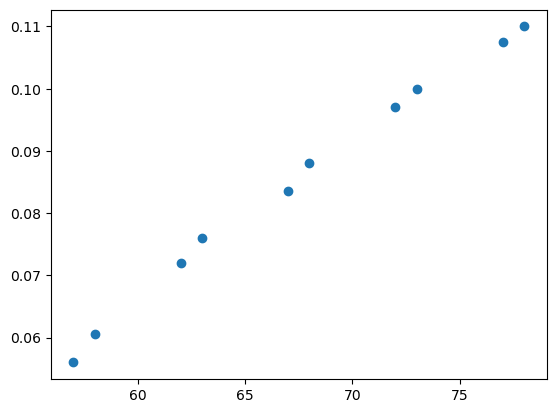

In [3]:
# Import the atually clinical data and plot

# Data for Gm and Gf
Gm = [
    [57, 16.8, 6.7, 0.6],
    [62, 18.1, 8.3, 1.0],
    [67, 19.2, 9.3, 1.3],
    [72, 19.9, 10.1, 2.0],
    [77, 19.1, 10.5, 2.6],
    [58, 17.9, 7.1, 0.7],
    [63, 19.1, 8.7, 1.1],
    [68, 20.1, 9.7, 1.5],
    [73, 20.6, 10.3, 2.1],
    [78, 19.6, 10.6, 2.7]
]

Gf = [
    [57, 10.1, 3.6, 0.3],
    [62, 11.4, 4.6, 0.5],
    [67, 12.6, 5.4, 0.7],
    [72, 13.7, 6.2, 1.1],
    [77, 13.5, 6.8, 1.6],
    [58, 10.9, 3.9, 0.4],
    [63, 12.2, 4.9, 0.5],
    [68, 13.4, 5.6, 0.8],
    [73, 14.3, 6.4, 1.2],
    [78, 13.9, 7.0, 1.7]
]

# Calculate incidence per age
Gm_data = [[row[0], (row[2] + row[3]) / 100] for row in Gm]
Gf_data = [[row[0], (row[2] + row[3]) / 100] for row in Gf]

# Sort both data sets
Gm_data_sort = sorted(Gm_data, key=lambda x: x[0])
GF_data_sort = sorted(Gf_data, key=lambda x: x[0])

# Average and sort
data = [[x[0], (x[1] + y[1]) / 2] for x, y in zip(Gm_data_sort, GF_data_sort)]
data_sorted = sorted(data, key=lambda x: x[0])

# Extract x and y values for plotting
x_dat = [row[0] for row in data_sorted]
y_dat = [row[1] for row in data_sorted]
plt.scatter(x_dat,y_dat)

Best Parameter Sets:
1. SSE: 0.0000, R: 156.00, KA: 5.62e+02, KR: 1.78e+03
2. SSE: 0.0001, R: 168.00, KA: 1.78e+01, KR: 1.33e+03
3. SSE: 0.0001, R: 168.00, KA: 1.33e+01, KR: 1.33e+03
4. SSE: 0.0001, R: 168.00, KA: 1.00e+01, KR: 1.33e+03
5. SSE: 0.0001, R: 168.00, KA: 2.37e+01, KR: 1.33e+03
6. SSE: 0.0001, R: 168.00, KA: 3.16e+01, KR: 1.33e+03
7. SSE: 0.0001, R: 168.00, KA: 4.22e+01, KR: 1.33e+03
8. SSE: 0.0001, R: 168.00, KA: 5.62e+01, KR: 1.33e+03
9. SSE: 0.0001, R: 168.00, KA: 7.50e+01, KR: 1.33e+03
10. SSE: 0.0001, R: 174.00, KA: 4.22e+02, KR: 1.00e+03


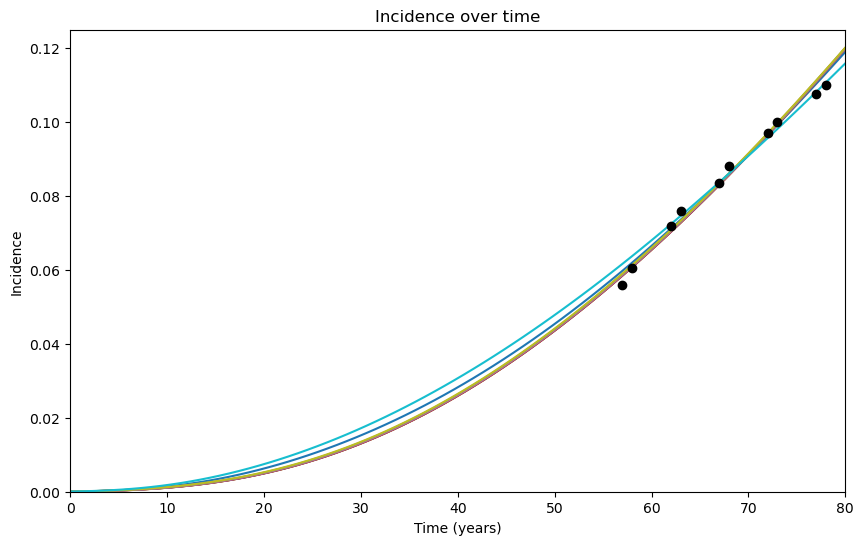

In [4]:
# Iterate over a range of parameters to find the best fit
# Initial Parameters
N_crypts = 1e+7
rmin = 150
rmax = 270
rsteps = 20
r_array = np.linspace(rmin, rmax, rsteps + 1)  # R values

gamma3 = 0.2
gamma4 = 0.07
gamma5 = 0.07
delta = 0.05
kmin = 1
kmax = 3.5
ksteps = 20
ka_array = np.logspace(kmin, kmax, ksteps + 1)  # KA values (logarithmic scale)
kr_array = np.logspace(kmin, kmax, ksteps + 1)  # KR values (logarithmic scale)

# Error tracking
errors = []

# Iterate through parameters
for r_1 in r_array:
    u = 10e-7 * r_1
    mu = 10e-9 * r_1

    for ka in ka_array:
        for kr in kr_array:
            # Solve ODE system
            sol = solve_ivp(
                ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
                args=(2*u, mu, u, mu, mu, 2*u, u, ka, kr, gamma3, gamma4, gamma5, delta)
            )
            
            # Adjust x_dat to match the time step (shift by 4.79)
            t_search = np.array(x_dat) + 4.79
            
            # Match data to model
            model_values = np.interp(t_search, sol.t, sol.y[5, :]) * (1 - delta / 1.01199)
            
            # Calculate SSE
            sse = np.sum((model_values - y_dat)**2)
            
            # Store parameters and error
            errors.append((sse, r_1, ka, kr))

# Sort errors by SSE
errors = sorted(errors, key=lambda x: x[0])

# Get the best parameter sets
best_params = errors[:10]

print("Best Parameter Sets:")
for rank, (sse, r_1, ka, kr) in enumerate(best_params, start=1):
    print(f"{rank}. SSE: {sse:.4f}, R: {r_1:.2f}, KA: {ka:.2e}, KR: {kr:.2e}")

# Plot the best models
plt.figure(figsize=(10, 6))
for _, r_1, ka, kr in best_params:
    u = 10e-7 * r_1
    mu = 10e-9 * r_1
    
    sol = solve_ivp(
        ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
        args=(2*u, mu, u, mu, mu, 2*u, u, ka, kr, gamma3, gamma4, gamma5, delta)
    )

    # Get model values for plotting
    model_values = sol.y[5, :] * (1 - delta / 1.01199)
    plt.plot(sol.t - 4.79, model_values, zorder=1) #label=f"R={r_1:.2f}, KA={ka:.2e}, KR={kr:.2e}")

# Plot observed data
plt.scatter(x_dat, y_dat, color='black', zorder=2, label="Observed Data")

# Add labels, legend, and title
plt.xlabel('Time (years)')
plt.ylabel('Incidence')
plt.xlim(0, 80)
plt.ylim(0,0.125)
plt.title("Incidence over time")
#plt.legend(loc='upper left')
plt.show()


In [5]:
# Our Best
r1 = 156
u = 10e-7 * r1
mu = 10e-9 * r1
values = {
    "N_crypts": 1e+7,
    "r1": r1,
    "u": u,
    "mu": mu,
    "gamma3": 0.2,
    "gamma4": 0.07,
    "gamma5": 0.07,
    "delta": 0.05,
    "KA": 562,
    "KR": 1780,
    "R12": 2 * u,
    "R14": mu,
    "R23": u,
    "R25": mu,
    "R36": mu,
    "R45": 2 * u,
    "R56": u,
}
globals().update(values)

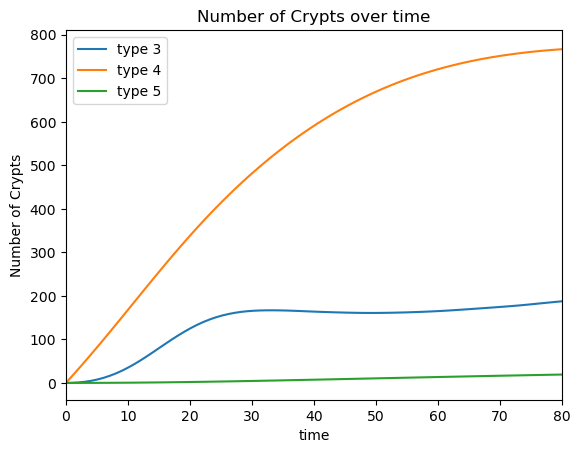

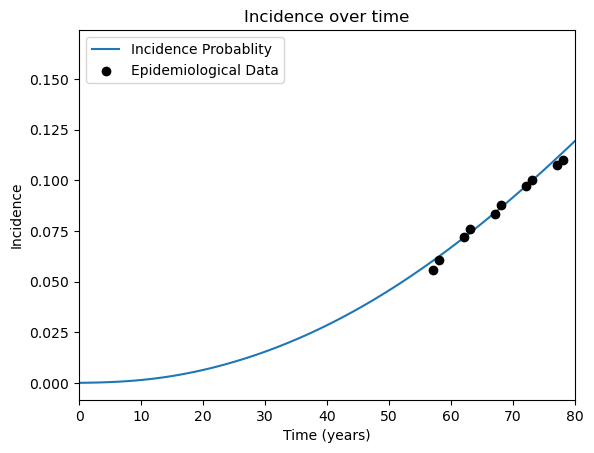

In [6]:
sol = solve_ivp(ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

# plt.plot(sol.t, sol.y[0,:], label='1') # this is too big to plot
# plt.plot(sol.t, sol.y[1,:], label="type 2") # linear growth
plt.plot(sol.t, sol.y[2,:], label="type 3")
plt.plot(sol.t, sol.y[3,:], label="type 4")
plt.plot(sol.t, sol.y[4,:], label="type 5")
plt.xlim(0,80)
plt.xlabel('time')
plt.ylabel('Number of Crypts')
plt.legend(loc='upper left')
plt.title("Number of Crypts over time")
plt.savefig('figures/Simulation.png')
plt.show()

plt.plot(sol.t-4.97, sol.y[5,:]*(1-delta/1.01199), zorder=1, label='Incidence Probablity')
plt.scatter(x_dat,y_dat,color='k', zorder=2, label='Epidemiological Data')
plt.xlim(0,80)
plt.xlabel('Time (years)')
plt.ylabel('Incidence')
plt.legend(loc='upper left')
plt.title("Incidence over time")
plt.savefig('figures/SimulationIncidenceProbabililty.png')
plt.show()

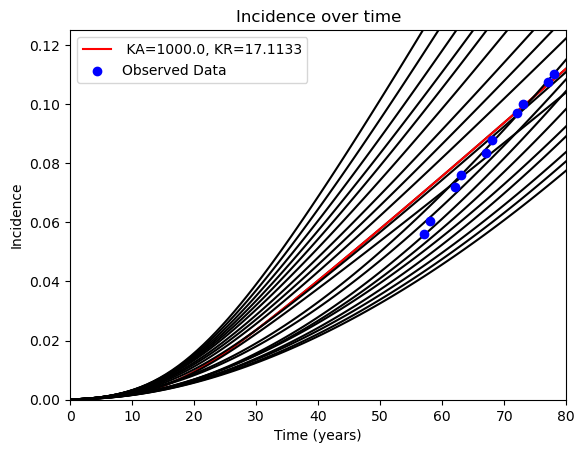

In [7]:
#Paper Test Values
K_vals = np.array([
    [1646.9, 1258.93],
    [1467.8, 1122.02],
    [1359.36, 926.119],
    [1258.93, 794.328],
    [1122.02, 764.422],
    [1079.78, 607.202],
    [1122.02, 354.813],
    [1079.78, 261.016],
    [1039.12, 171.133],
    [1000., 17.1133],
    [926.119, 107.978],
    [891.251, 26.1016],
    [207.332, 501.187],
    [171.133, 446.684],
    [10., 413.682],
    [23.2631, 368.695],
    [65.5642, 328.599],
    [10., 304.322],
    [31.6228, 271.227],
    [10., 251.189],
    [10., 232.631]
])

r1 = 204 #Keeping r1 constant (as best value)
u = 10e-7 * r1
mu = 10e-9 * r1
K_a = K_vals[:,0]
K_r = K_vals[:,1]

for x,y in zip(K_a,K_r):
    sol = solve_ivp(
    ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, x, y, gamma3, gamma4, gamma5, delta)
    )
    model_values = sol.y[5, :] * (1 - delta / 1.01199)
    plt.plot(sol.t - 4.79, model_values, color='k', zorder=1) #label=f"R={r_1:.2f}, KA={ka:.2e}, KR={kr:.2e}")
    if x==1000:
        plt.plot(sol.t - 4.79, model_values, color='red', zorder=1, label=f" KA={x}, KR={y}")

# Plot observed data
plt.scatter(x_dat, y_dat, color='blue', zorder=2, label="Observed Data")

plt.xlabel('Time (years)')
plt.ylabel('Incidence')
plt.xlim(0, 80)
plt.ylim(0,0.125)
plt.title("Incidence over time")
plt.legend(loc='upper left')
plt.show()

In [8]:
# Linearization
from sympy import symbols, Matrix

# Define the symbols with "_symbol" suffix
R12_symbol, R14_symbol, R23_symbol, R25_symbol, R36_symbol, R45_symbol, R56_symbol = symbols('R12_symbol R14_symbol R23_symbol R25_symbol R36_symbol R45_symbol R56_symbol')
K_A_symbol, K_R_symbol, gamma3_symbol, gamma4_symbol, gamma5_symbol, delta_symbol = symbols('K_A_symbol K_R_symbol gamma3_symbol gamma4_symbol gamma5_symbol delta_symbol')
n3_symbol, n4_symbol, n5_symbol, P_symbol = symbols('n3_symbol n4_symbol n5_symbol P_symbol')

# Define A, B, and C with the updated symbols
A = -R36_symbol + gamma3_symbol - (2 * gamma3_symbol * n3_symbol) / K_A_symbol - (gamma3_symbol * n4_symbol) / K_A_symbol - (gamma3_symbol * n5_symbol) / K_A_symbol - delta_symbol
B = -R45_symbol + gamma4_symbol - (gamma4_symbol * n3_symbol) / K_R_symbol - (2 * gamma4_symbol * n4_symbol) / K_R_symbol - (gamma4_symbol * n5_symbol) / K_R_symbol - delta_symbol
C = -R56_symbol + gamma5_symbol - (gamma5_symbol * n3_symbol) / K_R_symbol - (gamma5_symbol * n4_symbol) / K_R_symbol - (2 * gamma5_symbol * n5_symbol) / K_R_symbol - delta_symbol

# Define the matrix J with updated symbols
J = Matrix([
    [-R12_symbol - R14_symbol, 0, 0, 0, 0, 0],
    [R12_symbol, -R23_symbol - R25_symbol, 0, 0, 0, 0],
    [0, R23_symbol, A, -gamma3_symbol * n3_symbol / K_A_symbol, -gamma3_symbol * n3_symbol / K_A_symbol, 0],
    [R14_symbol, 0, -gamma4_symbol * n4_symbol / K_R_symbol, B, -gamma4_symbol * n4_symbol / K_R_symbol, 0],
    [0, R25_symbol, -gamma5_symbol * n5_symbol / K_R_symbol, R45_symbol - gamma5_symbol * n5_symbol / K_R_symbol, C, 0],
    [0, 0, R36_symbol - R36_symbol * P_symbol, 0, R56_symbol - R56_symbol * P_symbol, -R56_symbol * n5_symbol - R36_symbol * n3_symbol]
])

# Substitute n3, n4, n5, and P = 0 into the matrix (1st equilibrium points)
J_equilibrium = J.subs({n3_symbol: 0, n4_symbol: 0, n5_symbol: 0, P_symbol: 0})

# Display the resulting matrix
print("Matrix J at equilibrium points:")
print(J_equilibrium)
J_result = np.array(J_equilibrium.subs({
    R12_symbol: values["R12"],
    R14_symbol: values["R14"],
    R23_symbol: values["R23"],
    R25_symbol: values["R25"],
    R36_symbol: values["R36"],
    R45_symbol: values["R45"],
    R56_symbol: values["R56"],
    K_A_symbol: values["KA"],
    K_R_symbol: values["KR"],
    gamma3_symbol: values["gamma3"],
    gamma4_symbol: values["gamma4"],
    gamma5_symbol: values["gamma5"],
    delta_symbol: values["delta"],
}).tolist(), dtype=float)

print("Matrix J Result in:")
print(J_result)

Matrix J at equilibrium points:
Matrix([[-R12_symbol - R14_symbol, 0, 0, 0, 0, 0], [R12_symbol, -R23_symbol - R25_symbol, 0, 0, 0, 0], [0, R23_symbol, -R36_symbol - delta_symbol + gamma3_symbol, 0, 0, 0], [R14_symbol, 0, 0, -R45_symbol - delta_symbol + gamma4_symbol, 0, 0], [0, R25_symbol, 0, R45_symbol, -R56_symbol - delta_symbol + gamma5_symbol, 0], [0, 0, R36_symbol, 0, R56_symbol, 0]])
Matrix J Result in:
[[-3.1356000e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.1200000e-04 -1.5756000e-04  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  1.5600000e-04  1.4999844e-01  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.5600000e-06  0.0000000e+00  0.0000000e+00  1.9688000e-02
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  1.5600000e-06  0.0000000e+00  3.1200000e-04
   1.9844000e-02  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  1.5600000e-06  0.0000000e+00
   1.5600000e-04  0.0000000e+00]]


In [9]:
# Sensitivity Analysis on Transition Matrix
A = np.array([
    [1 - (R12 + R14), 0, 0, 0, 0],
    [R12, 1-(R23 + R25), 0, 0, 0],
    [0, R23, (1-R36)+gamma3-delta, 0, 0],
    [R14, 0, 0, (1-R45)+gamma4-delta, 0],
    [0, R25, 0, R45, (1-R56)+gamma5-delta]
])

# compute sensitivity and elasticity matrix
l_right, v_right = sortEig(J_result)
v_right_max = v_right[:,-1]

l_left, v_left = sortEig(np.transpose(J_result))
v_left_max = v_left[:,-1]

np.set_printoptions(precision=4)
S = np.outer(v_left_max,v_right_max) / np.dot(v_left_max,v_right_max)
print("sensitivities matrix S =\n", np.real(S))

max_value_S = np.max(S)
max_position_S = np.unravel_index(np.argmax(S), S.shape)

print("Max Value:", max_value_S)
print("Max Position:", max_position_S)

sensitivities matrix S =
 [[0.0000e+00 0.0000e+00 2.1565e-06 0.0000e+00 0.0000e+00 2.2427e-11]
 [0.0000e+00 0.0000e+00 1.0389e-03 0.0000e+00 0.0000e+00 1.0805e-08]
 [0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0400e-05]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]
Max Value: 1.0
Max Position: (2, 2)


Case 1: SSE = 0.019120749041240625
Case 2: SSE = 0.016501633820958456
Case 3: SSE = 0.0001019466442149332
Case 4: SSE = 0.01652337068473914
Case 5: SSE = 0.014605796647564569
Case 6: SSE = 6.588787448636283e-05
Case 7: SSE = 0.39715176610950165
Case 8: SSE = 0.029187746084587685
Case 9: SSE = 0.00010109781810342373
Case 10: SSE = 0.025448761339225016


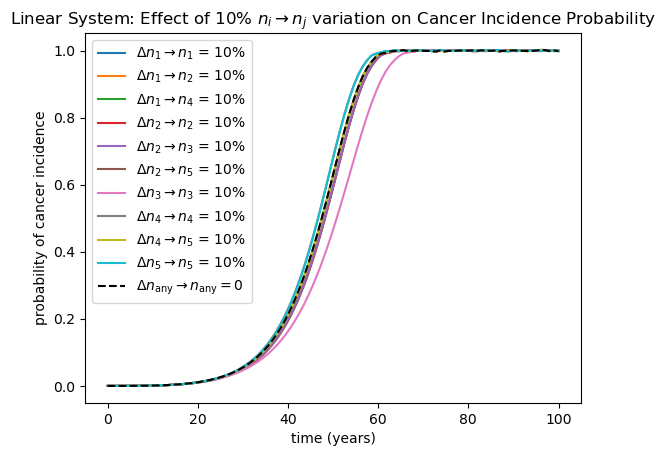

In [10]:
# simulated variation in linear ode system
vary = 0.9
sol_0 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_11 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u*vary, mu*vary, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_12 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u*vary, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_14 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu*vary, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_22 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u*vary, mu*vary, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_23 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u*vary, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_25 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu*vary, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_33 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu*vary, 2*u, u, KA, KR, gamma3*vary, gamma4, gamma5, delta*vary))

sol_44 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u*vary, u, KA, KR, gamma3, gamma4*vary, gamma5, delta*vary))
sol_45 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u*vary, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_55 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u*vary, KA, KR, gamma3, gamma4, gamma5*vary, delta*vary))

# Compute SSE (Sum of Squared Errors) for each case. Notice the less the SSE the less the perturbation due to varying parameters. So we are looking for the max deviation.
SSEs = []
for i, sol_case in enumerate([sol_11, sol_12, sol_14, sol_22, sol_23, sol_25, sol_33, sol_44, sol_45, sol_55], start=1):
    sse = np.sum((sol_0.y[5, :] - sol_case.y[5, :]) ** 2)
    print(f"Case {i}: SSE = {sse}")
    SSEs.append(sse)

plt.plot(sol.t, sol_11.y[5, :], label=fr'$\Delta n_1 \rightarrow n_1$ = 10%')
plt.plot(sol.t, sol_12.y[5, :], label=fr'$\Delta n_1 \rightarrow n_2$ = 10%')
plt.plot(sol.t, sol_14.y[5, :], label=fr'$\Delta n_1 \rightarrow n_4$ = 10%')
plt.plot(sol.t, sol_22.y[5, :], label=fr'$\Delta n_2 \rightarrow n_2$ = 10%')
plt.plot(sol.t, sol_23.y[5, :], label=fr'$\Delta n_2 \rightarrow n_3$ = 10%')
plt.plot(sol.t, sol_25.y[5, :], label=fr'$\Delta n_2 \rightarrow n_5$ = 10%')
plt.plot(sol.t, sol_33.y[5, :], label=fr'$\Delta n_3 \rightarrow n_3$ = 10%')
plt.plot(sol.t, sol_44.y[5, :], label=fr'$\Delta n_4 \rightarrow n_4$ = 10%')
plt.plot(sol.t, sol_45.y[5, :], label=fr'$\Delta n_4 \rightarrow n_5$ = 10%')
plt.plot(sol.t, sol_55.y[5, :], label=fr'$\Delta n_5 \rightarrow n_5$ = 10%')
plt.plot(sol.t, sol_0.y[5,:], label=fr'$\Delta n_{{\mathrm{{any}}}} \rightarrow n_{{\mathrm{{any}}}} = 0$', linestyle='--', color='black')

plt.xlabel('time (years)')
plt.ylabel('probability of cancer incidence')
plt.legend(loc='upper left')
plt.title(fr"Linear System: Effect of 10% $n_i \rightarrow n_j$ variation on Cancer Incidence Probability")
plt.savefig('figures/LinearSensitivity.png')
plt.show()

Case 1: SSE = 0.00401031263557022
Case 2: SSE = 0.0036025402421686224
Case 3: SSE = 2.149145574009584e-05
Case 4: SSE = 0.003617431640889789
Case 5: SSE = 1.7078178028584596e-05
Case 6: SSE = 0.003366733264040264
Case 7: SSE = 0.0051320812555850776
Case 8: SSE = 0.001833600773835744
Case 9: SSE = 0.00231532508844843
Case 10: SSE = 0.007376358895871077


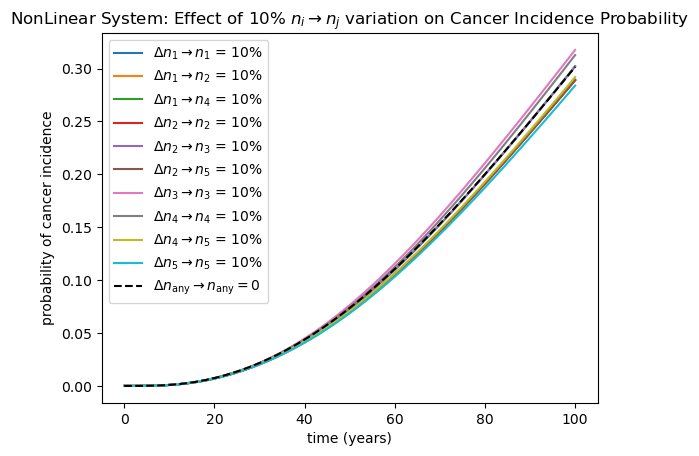

In [11]:
# simulated variation in linear ode system
vary = 0.9
sol_0 = solve_ivp(ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_11 = solve_ivp(ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u*vary, mu*vary, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_12 = solve_ivp(ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u*vary, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_14 = solve_ivp(ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu*vary, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_22 = solve_ivp(ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u*vary, mu*vary, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_23 = solve_ivp(ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u*vary, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))
sol_25 = solve_ivp(ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu*vary, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_33 = solve_ivp(ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu*vary, 2*u, u, KA, KR, gamma3*vary, gamma4, gamma5, delta*vary))

sol_44 = solve_ivp(ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u*vary, u, KA, KR, gamma3, gamma4*vary, gamma5, delta*vary))
sol_45 = solve_ivp(ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u*vary, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_55 = solve_ivp(ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u*vary, KA, KR, gamma3, gamma4, gamma5*vary, delta*vary))

# Compute SSE (Sum of Squared Errors) for each case. Notice the less the SSE the less the perturbation due to varying parameters. So we are looking for the max deviation.
SSEs = []
for i, sol_case in enumerate([sol_11, sol_12, sol_14, sol_22, sol_23, sol_25, sol_33, sol_44, sol_45, sol_55], start=1):
    sse = np.sum((sol_0.y[5, :] - sol_case.y[5, :]) ** 2)
    print(f"Case {i}: SSE = {sse}")
    SSEs.append(sse)

plt.plot(sol.t, sol_11.y[5, :], label=fr'$\Delta n_1 \rightarrow n_1$ = 10%')
plt.plot(sol.t, sol_12.y[5, :], label=fr'$\Delta n_1 \rightarrow n_2$ = 10%')
plt.plot(sol.t, sol_14.y[5, :], label=fr'$\Delta n_1 \rightarrow n_4$ = 10%')
plt.plot(sol.t, sol_22.y[5, :], label=fr'$\Delta n_2 \rightarrow n_2$ = 10%')
plt.plot(sol.t, sol_23.y[5, :], label=fr'$\Delta n_2 \rightarrow n_3$ = 10%')
plt.plot(sol.t, sol_25.y[5, :], label=fr'$\Delta n_2 \rightarrow n_5$ = 10%')
plt.plot(sol.t, sol_33.y[5, :], label=fr'$\Delta n_3 \rightarrow n_3$ = 10%')
plt.plot(sol.t, sol_44.y[5, :], label=fr'$\Delta n_4 \rightarrow n_4$ = 10%')
plt.plot(sol.t, sol_45.y[5, :], label=fr'$\Delta n_4 \rightarrow n_5$ = 10%')
plt.plot(sol.t, sol_55.y[5, :], label=fr'$\Delta n_5 \rightarrow n_5$ = 10%')
plt.plot(sol.t, sol_0.y[5,:], label=fr'$\Delta n_{{\mathrm{{any}}}} \rightarrow n_{{\mathrm{{any}}}} = 0$', linestyle='--', color='black')

plt.xlabel('time (years)')
plt.ylabel('probability of cancer incidence')
plt.legend(loc='upper left')
plt.title(fr"NonLinear System: Effect of 10% $n_i \rightarrow n_j$ variation on Cancer Incidence Probability")
plt.savefig('figures/NonLinearSensitivity.png')
plt.show()